# Mushrooms classification - Tensorflow

This notebook is used to build and train a binary classification neural network. We will train it for the [Kaggle - Mushroom Classification](https://www.kaggle.com/uciml/mushroom-classification) project. The data should be already processed and saved to .npy files. See the `mushrooms_data_preparation.ipynb` notebook from this repository to process the data.

### Import used modules

The only external modules used for this notebook are [numpy](http://www.numpy.org/), [tensorflow](https://www.tensorflow.org/), and [matplotlib](https://matplotlib.org/).

In [1]:
%matplotlib inline

import sys
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

SCRIPT_DIR = Path.cwd()
sys.path.append(str(SCRIPT_DIR.parent))

from data_utils.data_iterator import DataIterator

## Load the processed data

First we need to load the processed data. This files are loaded as numpy arrays.

In [2]:
training_data = np.load(open("training_data/mushrooms_training_data.npy", 'rb'))
training_labels = np.load(open("training_data/mushrooms_training_labels.npy", 'rb'))
validation_data = np.load(open("training_data/mushrooms_validation_data.npy", 'rb'))
validation_labels = np.load(open("training_data/mushrooms_validation_labels.npy", 'rb'))
test_data = np.load(open("training_data/mushrooms_test_data.npy", 'rb'))
test_labels = np.load(open("training_data/mushrooms_test_labels.npy", 'rb'))

Print data type and arrays shapes.

In [3]:
print("Loaded data type = {}".format(type(training_data)))
print("Training data shape = {}".format(training_data.shape))
print("Training labels shape = {}".format(training_labels.shape))
print("Validation data shape = {}".format(validation_data.shape))
print("Validation labels shape = {}".format(validation_labels.shape))
print("Test data shape = {}".format(test_data.shape))
print("Test labels shape = {}".format(test_labels.shape))

Loaded data type = <class 'numpy.ndarray'>
Training data shape = (6500, 117)
Training labels shape = (6500, 1)
Validation data shape = (812, 117)
Validation labels shape = (812, 1)
Test data shape = (812, 117)
Test labels shape = (812, 1)


## Create model

Now we will define our neural network model. We will create a tensorflow graph that we can later train. This graph should have:
- **Placeholders**: These are the model inputs. When training or evaluating the model, we will feed the graph through this operations with out data.
- **Hidden layers**: In this model we will use a stack of [fully connected layers](https://www.tensorflow.org/api_docs/python/tf/layers/dense). The number, size and activation function of this layers can be changed from the model parameters variables.
- **Output layer**: We will use a fully connected layer, with size 1 (one neuron) and a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function (the standart output function for binary classification).
- **Cost computation**: We need a tensorflow operation to calculate the cost of the current model prediction, with respect to the real labels. We will use the [logarithmic loss](https://datawookie.netlify.com/blog/2015/12/making-sense-of-logarithmic-loss/) for this task.
- **Training operations**: This tensorflow operations will be used to perform one training step (gradients calculation and parameters update) so the model decrease the cost.
- **Summaries**: We will add [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) summaries to vizualize the model graph (architecture), the training process, and some parameters of the model.
- **Metrics**: We will add operations to check the performance of the model with respect to the true labels we are trying to predict.

### Model parameters

This parameters are used to easily change the model architecture to try different configurations and find the best for our specific task.

In [4]:
# Parameters
fully_connected_layers = 3
fully_connected_size = 50
fully_connected_activation = tf.nn.relu

### Create placeholders

The placeholders are created using the data shapes. The first dimension is `None`, because this is the batch size, and we want to change it for different runs.

In [5]:
# Data inputs
x = tf.placeholder(dtype=tf.float32, shape=[None, training_data.shape[1]], name="inputs")
print(x)
# Labels inputs
y = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="labels")
print(y)

# Learning rate input
learning_rate_input = tf.placeholder(dtype=tf.float32, shape=[], name="learning_rate")
print(learning_rate_input)

# Used in training to keep track of variables updates
global_step = tf.get_variable(name="global_step",
                              shape=[],
                              dtype=tf.int32,
                              initializer=tf.constant_initializer(0),
                              trainable=False)
print(global_step)

Tensor("inputs:0", shape=(?, 117), dtype=float32)
Tensor("labels:0", shape=(?, 1), dtype=float32)
Tensor("learning_rate:0", shape=(), dtype=float32)
<tf.Variable 'global_step:0' shape=() dtype=int32_ref>


### Create hidden layers

In [6]:
dense_layers = fully_connected_layers

# Create first dense layer
# Shape: (batch_size, fully_connected_size)
dense = tf.layers.dense(x,
                        units=fully_connected_size,
                        activation=fully_connected_activation,
                        name="dense_1")

print(dense)

dense_layers -= 1
dense_layer_count = 2

# Create next dense layers
for i in range(dense_layers):
    # Shape: (batch_size, fully_connected_size)
    dense = tf.layers.dense(dense,
                            units=fully_connected_size,
                            activation=fully_connected_activation,
                            name="dense_{}".format(dense_layer_count))
    
    print(dense)
    
    dense_layer_count += 1

Tensor("dense_1/Relu:0", shape=(?, 50), dtype=float32)
Tensor("dense_2/Relu:0", shape=(?, 50), dtype=float32)
Tensor("dense_3/Relu:0", shape=(?, 50), dtype=float32)


### Create output layer

In [7]:
# Shape: (batch_size, 1)
output_layer = tf.layers.dense(dense, 
                               units=1, 
                               activation=tf.nn.sigmoid,
                               name="output")

print(output_layer)

Tensor("output/Sigmoid:0", shape=(?, 1), dtype=float32)


### Cost and Optimizer

Now we create the tensorflow operations to calculate the cost of the model and perform one training step. We will use gradient descent to optimize our model.

In [8]:
with tf.variable_scope("cost_and_optimizer"):
    
    # Loss value for the model output of each data point fed to the graph
    # Shape: (batch_size, 1)
    loss_op = tf.nn.sigmoid_cross_entropy_with_logits(labels=y,
                                                      logits=output_layer,
                                                      name="loss_op")
    print(loss_op)
    
    # Cost value for all the data points fed to the model
    # Shape: ()
    cost = tf.reduce_sum(loss_op, name="cost")
    print(cost)
    
    # Model optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate_input,
                                                 name="gradient_descent_optimizer")
    
    # Trining operation. Perform one parameters update. Increment global_step by 1.
    training_op = optimizer.minimize(cost, global_step=global_step)

Tensor("cost_and_optimizer/loss_op:0", shape=(?, 1), dtype=float32)
Tensor("cost_and_optimizer/cost:0", shape=(), dtype=float32)


### Model metrics

In [9]:
# The model ouputs a value between 0 and 1. We need to transform 
# it to the predicted label (0 or 1)
predictions = tf.round(output_layer, name="predictions")

# Metrics
with tf.name_scope("metrics"):
    # Get the model accuracy.
    accuracy = tf.metrics.accuracy(labels=y,
                                   predictions=predictions,
                                   name="accuracy")

### Tensorboard summaries

In [10]:
tensorboard_logs_dir = Path(Path.cwd(), "tensorboard_logs")
tensorboard_logs_dir.mkdir(exist_ok=True)

with tf.name_scope("summaries"):
    tf.summary.scalar("cost", cost)
    tf.summary.scalar("accuracy", accuracy[0])
    tf.summary.histogram("output_layer", output_layer)
    summary_op = tf.summary.merge_all()

## Model training

Now it's time to train the model!

We will feed the data to the graph, one batch at a time. We will perform a parameters update each time we feed a batch ([mini batch gradient descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)).

Every some training steps, we will evaluate the model on the validation data, to check how the model is performing on data not used for training.

### Training hyperparameters

These are the hyperparameters we need to tune in order to get the model and training to work. Try different values to see how the training and model performance change.

In [11]:
# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.001

### Create lists of batchs

The batches are generated using the DataIterator of this repository. It outputs a batch of the required size at a time. It can shuffle the data before creating the batches, so the composition of each batch is different for each epoch (full pass over the entire training data).

In [12]:
training_iterator = DataIterator(data=training_data,
                                 labels=training_labels,
                                 batch_size=batch_size,
                                 shuffle=True)

validation_iterator = DataIterator(data=validation_data,
                                   labels=validation_labels,
                                   batch_size=batch_size,
                                   shuffle=True)

### Training operations

Now that we have the model graph, the training operations, and the data batch generators, we can train the model.

In [13]:
## Useful variables
# Validate the model every some global steps and print information
val_period = 10
# Save the model to file every some global steps
save_period = 20

In [18]:
# Tensorboard files
tensorboard_job_name = "tensorflow_dl_{}-ds_{}-lr_{}-e_{}-b_{}".format(fully_connected_layers,
                                                                       fully_connected_size,
                                                                       learning_rate,
                                                                       epochs,
                                                                       batch_size)
tensorboard_log_dir = Path(tensorboard_logs_dir, tensorboard_job_name)

# This tensorflow operations are used to initialize all the variables of the model.
init_op = tf.global_variables_initializer()
init_l_op = tf.local_variables_initializer()

global_step_count = 0

with tf.Session() as sess:
    
    # Initialize graph variables
    sess.run(init_op)
    sess.run(init_l_op)
    
    # Training and validation Tensorboard files writers
    train_writer = tf.summary.FileWriter(str(Path(tensorboard_log_dir, "train")),
                                         sess.graph)
    validation_writer = tf.summary.FileWriter(str(Path(tensorboard_log_dir, "validation")),
                                              sess.graph)
    
    # Set up a Saver for periodically serializing the model
    saver = tf.train.Saver(max_to_keep=5)
    
    # Create list to store usefull data
    training_costs = []
    training_accuracies = []
    validation_costs = []
    validation_accuracies = []
    
    # Iterate over the entire data
    for epoch in range(epochs):
        
        # Iterate over a generator that returns batches
        for train_batch in training_iterator:
            
            global_step_count = sess.run(global_step)
            
            feed_dict = {x: train_batch[0],
                         y: train_batch[1],
                         learning_rate_input: learning_rate}
            
            # Do a gradient update, and log results to Tensorboard               
            train_cost, train_accuracy, _, train_summary = sess.run(
                [cost, accuracy, training_op, summary_op],
                feed_dict=feed_dict)
            train_writer.add_summary(train_summary, global_step_count)
            
            training_costs.append(train_cost)
            training_accuracies.append(train_accuracy[0])
            
            # Evaluate the model on validation set every val_period steps
            if global_step_count % val_period == 0:
                
                val_batch_accuracies = []
                val_batch_costs = []
                
                # Evaluate on validation data
                for val_batch in validation_iterator:
                    
                    validation_feed_dict = {x: val_batch[0],
                                            y: val_batch[1]}
                    
                    val_batch_accuracy, val_batch_cost = sess.run(
                        [accuracy, cost],
                        feed_dict=validation_feed_dict)
                    
                    val_batch_accuracies.append(np.sum(val_batch_accuracy[0]))
                    val_batch_costs.append(np.sum(val_batch_cost))
                
                mean_val_accuracy = np.sum(np.array(val_batch_accuracies)) / validation_iterator.total_batches
                mean_val_cost = np.sum(np.array(val_batch_costs)) / validation_iterator.total_batches
                
                val_summary = tf.Summary(value=[
                    tf.Summary.Value(tag="val_summaries/accuracy",
                                     simple_value=mean_val_accuracy),
                    tf.Summary.Value(tag="val_summaries/cost",
                                     simple_value=mean_val_cost)])
                
                validation_writer.add_summary(val_summary, global_step_count)
                
                validation_costs.append(mean_val_cost)
                validation_accuracies.append(mean_val_accuracy)
                
                # Print information abuot training
                print("Epoch {} - Global step {} - Training cost {} - Training accuracy {} - "
                      "Validation cost {} - Validation accuracy {}".format(epoch,
                                                                           global_step_count,
                                                                           train_cost,
                                                                           train_accuracy[0],
                                                                           mean_val_cost,
                                                                           mean_val_accuracy))
            
            # Write a model checkpoint if necessary.
            if global_step_count % save_period == 0:
                Path(Path.cwd(), "trained_models", "tensorflow").mkdir(exist_ok=True, parents=True)
                save_path = saver.save(sess, "./trained_models/tensorflow/model.ckpt")
                print("Model saved in path: {}".format(save_path))
    
    # Done training!
    print("Finished {} epochs!".format(epoch + 1))

Epoch 0 - Global step 0 - Training cost 90.17144775390625 - Training accuracy 0.0 - Validation cost 96.55787004743304 - Validation accuracy 0.679427078792027
Model saved in path: ./trained_models/tensorflow/model.ckpt
Epoch 0 - Global step 10 - Training cost 83.17745208740234 - Training accuracy 0.5865200757980347 - Validation cost 94.33516148158482 - Validation accuracy 0.6083534104483468
Epoch 0 - Global step 20 - Training cost 84.18740844726562 - Training accuracy 0.596319317817688 - Validation cost 92.26133510044643 - Validation accuracy 0.6118952887398856
Model saved in path: ./trained_models/tensorflow/model.ckpt
Epoch 0 - Global step 30 - Training cost 80.1304931640625 - Training accuracy 0.6247609853744507 - Validation cost 89.43201555524554 - Validation accuracy 0.6371228354317802
Epoch 0 - Global step 40 - Training cost 78.2999267578125 - Training accuracy 0.6651529669761658 - Validation cost 87.14884730747768 - Validation accuracy 0.6740110261099679
Model saved in path: ./tr

Epoch 8 - Global step 410 - Training cost 63.63737869262695 - Training accuracy 0.9205475449562073 - Validation cost 74.88872419084821 - Validation accuracy 0.9208041599818638
Epoch 8 - Global step 420 - Training cost 61.394874572753906 - Training accuracy 0.9218279123306274 - Validation cost 74.72414725167411 - Validation accuracy 0.9220888274056571
Model saved in path: ./trained_models/tensorflow/model.ckpt
Epoch 8 - Global step 430 - Training cost 62.320377349853516 - Training accuracy 0.9231600761413574 - Validation cost 74.73165457589286 - Validation accuracy 0.923382077898298
Epoch 8 - Global step 440 - Training cost 62.71239471435547 - Training accuracy 0.9243770837783813 - Validation cost 74.68520682198661 - Validation accuracy 0.9246336391993931
Model saved in path: ./trained_models/tensorflow/model.ckpt
Epoch 8 - Global step 450 - Training cost 61.93427276611328 - Training accuracy 0.9255930781364441 - Validation cost 74.58969552176339 - Validation accuracy 0.9258238247462681

Model saved in path: ./trained_models/tensorflow/model.ckpt
Epoch 15 - Global step 810 - Training cost 60.40536117553711 - Training accuracy 0.9523699879646301 - Validation cost 73.55629185267857 - Validation accuracy 0.952472414289202
Epoch 16 - Global step 820 - Training cost 61.060585021972656 - Training accuracy 0.9528334736824036 - Validation cost 73.57392229352679 - Validation accuracy 0.9529258183070591
Model saved in path: ./trained_models/tensorflow/model.ckpt
Epoch 16 - Global step 830 - Training cost 63.35520935058594 - Training accuracy 0.9532646536827087 - Validation cost 73.59140450613839 - Validation accuracy 0.9533612387520927
Epoch 16 - Global step 840 - Training cost 65.6666259765625 - Training accuracy 0.9536741375923157 - Validation cost 73.56125313895089 - Validation accuracy 0.9537691388811383
Model saved in path: ./trained_models/tensorflow/model.ckpt
Epoch 16 - Global step 850 - Training cost 61.44354248046875 - Training accuracy 0.9540964961051941 - Validation 

## Plot cost and accuracy during training

Now we plot the how the cost and accuracy change during training, for both the training data and the validation data. This information is also ploted in Tensorboard, but we plot it here anyways.

*Note: The training cost and accuracy is for one batch of data, but for the validation test, we plot the mean accuracy and cost over all the data batches.*

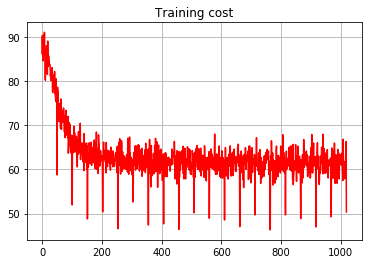

In [19]:
plt.plot(range(len(training_costs)), training_costs, color="red")
plt.title("Training cost")
plt.grid()

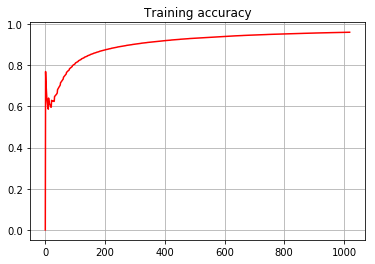

In [20]:
plt.plot(range(len(training_accuracies)), training_accuracies, color="red")
plt.title("Training accuracy")
plt.grid()

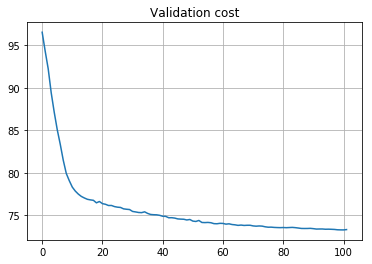

In [21]:
plt.plot(range(len(validation_costs)), validation_costs)
plt.title("Validation cost")
plt.grid()

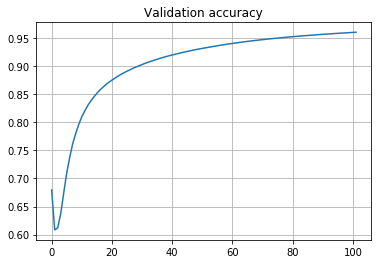

In [22]:
plt.plot(range(len(validation_accuracies)), validation_accuracies)
plt.title("Validation accuracy")
plt.grid()

## Test model

We will use the test data we have loaded to test our model performance on unseen data.

In [24]:
with tf.Session() as sess:
    
    saver.restore(sess, "trained_models/tensorflow/model.ckpt")
    
    sess.run(init_l_op)
    
    test_accuracy = sess.run(accuracy, feed_dict={x: test_data,
                                                  y: test_labels})

print("Test accuracy = {}".format(test_accuracy[1]))

INFO:tensorflow:Restoring parameters from trained_models/tensorflow/model.ckpt
Test accuracy = 0.9630541801452637


## Tensorboard

To use tensorboard open a console, go to the project folder (`"mushrooms"`) and type:

```bash
tensorboard --logdir tensoboard_logs\
```

### Tensoboard results

#### Model graph

The model graph shows the model architecture. The arrows represent the tensors flowing and their shape.

![graph](notebook_images/tensorflow_graph.png)

#### Output layer values

We can se the output layer values progress during training in this histogram. The distribution in the back shows the values when we start the training. There the we can see that the model outputs a lot of values near 0.5, but the model quickly learn to output values near 0 and 1. This layer has a sigmoid activation so the output values are always in the range (0, 1).

![output_layer_histograms](notebook_images/tensorflow_output_layer_histograms.png)

#### Train set cost and accuracy

Tensorboard shows us the scalar values we asked for, in this case the training set cost and accuracy.

![training_scalars](notebook_images/tensorflow_training_scalars.png)

#### Validation set cost and accuracy

We also add scalars in Tensorboard for the validation set cost and accuracy.

![validation_scalars](notebook_images/tensorflow_validation_scalars.png)